In [48]:
# imports

import numpy as np 
import os
import csv 

import pandas as pd 
import matplotlib.pyplot as plt 

from filterpy.kalman import predict
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter

from openpyxl import load_workbook

In [49]:
# settings

start_time = pd.Timestamp('2024-09-17 00:00:00-0400')
end_time = pd.Timestamp('2024-09-18 00:00:00-0400')

#data_dir = "../../data"
#home_dir = ""
data_dir = "/Users/monugoel/Desktop/CSDS_395/data/"
home_dir = "/Users/monugoel/Desktop/CSDS_395/"

In [50]:
# extract energy burned data

# energy burned inverse to hunger
# maybe energy burned should be offset

df = pd.read_csv(os.path.join(data_dir, "PhysicalEffort.csv"))
df['start'] = pd.to_datetime(df['start'])
df.set_index('start', inplace=True)
df.sort_index(inplace=True)

common_time = pd.date_range(start=start_time, end=end_time, freq='25T')
effort_aligned = df['value'].reindex(common_time, method='nearest')
# effort_interpolated = df.interpolate(method = 'linear')
aligned_df = pd.DataFrame({
    'value': effort_aligned
})

processed_effort = aligned_df.to_numpy().flatten()

# for i, row in aligned_df.iterrows(): print(f"time: {i}, value: {row['value']}")

/var/folders/qg/60cswt1n6kv3d9rv9xq0q42w0000gn/T/ipykernel_25014/663988184.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  common_time = pd.date_range(start=start_time, end=end_time, freq='25T')


In [51]:
# extract physical effort data

# physical effort should be inverse to hunger (not necessarily)

df = pd.read_csv(os.path.join(data_dir, "BasalEnergyBurned.csv"))
df['start'] = pd.to_datetime(df['start'])
df.set_index('start', inplace=True)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep='first')]

common_time = pd.date_range(start=start_time, end=end_time, freq='25T')
energy_aligned = df['value'].reindex(common_time, method='nearest')
aligned_df = pd.DataFrame({
    'value': energy_aligned
})

processed_energy = aligned_df.to_numpy().flatten()

# for i,row in aligned_df.iterrows(): print(f"time: {i}, value: {row['value']}")

/var/folders/qg/60cswt1n6kv3d9rv9xq0q42w0000gn/T/ipykernel_25014/2393657159.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  common_time = pd.date_range(start=start_time, end=end_time, freq='25T')


In [52]:
# extract hunger times data



In [53]:
# P matrix

#P = np.cov(np.array([processed_effort, processed_energy, ]))
P = np.array([[1]])

In [54]:
# zs matrix

n_steps = len(processed_energy)
zs = np.column_stack((processed_effort, processed_energy, ))

In [55]:
# initial state X

X = np.array([[0]])
print(X.shape)

(1, 1)


In [56]:
# process model matrix F

F = np.array([
[1]
])

In [57]:
# measurement noise covariance matrix R

# from SleepCycle.data_processing import calc_R

# R = np.array([
#     [1, 0],
#     [0, 1]
# ])

def calc_R(arrays):     
    unified_array = np.array(arrays)
    R = np.cov(unified_array)
    return R 
R = calc_R([processed_effort, processed_energy, ])
R

array([[  2.7141833 ,  -7.43308373],
       [ -7.43308373, 254.72669822]])

In [58]:
# process noise covariance matrix Q

#Q = Q_discrete_white_noise(dim=2, dt=1., var=1.0)

Q = np.array([[1]])

In [59]:
# measurement matrix H

H = np.array([
    [1],  # energy mapping
    [1],  # effort mapping
])

In [60]:
# kalman filter initialization

kf = KalmanFilter(dim_x=1, dim_z=2)
kf.x = X
kf.P = P
kf.R = R
kf.Q = Q
kf.F = F
kf.H = H

In [61]:
# Run the Kalman filter with your data
    
# Arrays to store state estimates and covariances
xs, cov = [], []
xs_rot = []
residuals = []

for i in range(n_steps):
    #kf_rot.F = rotation_matrix_4d_xy_xw(theta_xy, theta_xw)

    kf.predict()  # Predict the next state
    z = zs[i]     # Get the measurements for this time step
    kf.update(z)  # Update with the measurement

    xs.append(kf.x)  # Store the state estimate
    cov.append(kf.P) # Store the covariance matrix

    # Calculate residuals (difference between measurement and prediction)
    predicted_measurement = H @ kf.x  # Predicted measurement
    residual = z - predicted_measurement
    residuals.append(residual)

# Convert results to numpy arrays for easy handling
xs = np.array(xs)
cov = np.array(cov)
residuals = np.array(residuals) 

<class 'numpy.ndarray'>
(58, 1, 1)
(58, 1)
(58,)
Standard Deviation of Residuals: [1.08191191 1.08191191]
Mean Squared Error (MSE): [1.46554451 1.46554451]


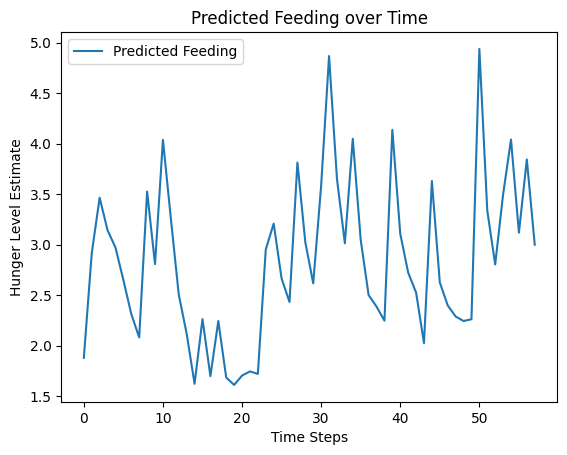

In [62]:
# evaluation

# xs now contains state estimates, including core body temperature estimates over time
print(type(xs))
print(np.shape(xs))

xs_reshaped = xs[:, 0]
print(np.shape(xs_reshaped))

np.savetxt(os.path.join(home_dir, "predictions_hunger.csv"), xs_reshaped, delimiter=",")

xs_cbt = xs_reshaped[:1440, 0]
print(np.shape(xs_cbt))
ys_cbt = np.arange(len(xs_cbt))

# Calculate Standard Deviation of Residuals and MSE
residual_std = np.std(residuals, axis=0)
mse = np.mean(residuals**2, axis=0)

residual_std_cbt = residual_std[:, 0]  # Extract standard deviation for CBT
mse_cbt = mse[:, 0]  # Extract MSE for CBT

print("Standard Deviation of Residuals:", residual_std_cbt)
print("Mean Squared Error (MSE):", mse_cbt)

plt.plot(ys_cbt, xs_cbt, label='Predicted Hunger')
plt.title('Predicted Hunger Level')
plt.xlabel('Time Steps')
plt.ylabel('Hunger Level Estimate')
plt.legend()

# Plot Residuals
"""
plt.subplot(2, 1, 2)  # Second plot in the grid
plt.plot(ys_cbt, residuals[:len(ys_cbt), 0], label='Residuals (Hunger)')
plt.title('Residuals of Core Body Temperature Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual (Measurement - Prediction)')
plt.legend()


# Show the final plot with both graphs
plt.tight_layout()
plt.savefig(os.path.join(home_dir, 'my_plot_kal_hunger_residuals.png'))
"""
plt.show()

